## Analysis of The Driving Hamiltonian

#### Imports

In [1]:
from collections import Counter
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy

def plot_spectrum(eigenvalues):
    """
    Plot the vertical spectrum of a Hamiltonian, showing the eigenvalues as horizontal lines 
    and indicating their degeneracy.

    Parameters:
    eigenvalues (array-like): Array of eigenvalues of the Hamiltonian.
    """
    # Count the degeneracy of each eigenvalue
    degeneracy = Counter(eigenvalues)

    # Prepare data for plotting
    unique_eigenvalues = list(degeneracy.keys())
    degeneracies = list(degeneracy.values())

    # Plot the spectrum
    plt.figure(figsize=(6, 10))
    for i, (eig, deg) in enumerate(zip(unique_eigenvalues, degeneracies)):
        plt.hlines(eig, i - 0.2 * deg, i + 0.2 * deg, colors='b', linewidth=5)
        plt.text(i, eig, f'{deg}', horizontalalignment='center', verticalalignment='bottom', fontsize=24, color='r')

    # Make the plot fancy
    plt.title('Spectrum of the Hamiltonian', fontsize=16)
    plt.ylabel('Eigenvalue', fontsize=14)
    plt.xlabel('Index (degeneracy indicated by text)', fontsize=14)
    plt.xticks(range(len(unique_eigenvalues)), ['']*len(unique_eigenvalues))  # Remove x-axis ticks
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

file_name='data/usdb.nat'
SPS=SingleParticleState(file_name=file_name)
energies=SPS.energies

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Hyperparameters

In [2]:
nparticles_a=6
nparticles_b=8

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




J and M operator and the single particle Basis

In [3]:
matrix_j,_=get_twobody_nuclearshell_model(file_name='data/j2.int')

energies=SPS.energies

diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,_,tz=SPS.state_encoding[i]
    label.append((j,m,tz))
    diag_j[i]=j*(j+1)
    diag_m[i]=m

# Joperator = FermiHubbardHamiltonian(
#     size_a=size_a,
#     size_b=size_b,
#     nparticles_a=nparticles_a,
#     nparticles_b=nparticles_b,
# )

# Joperator.get_twobody_interaction(twobody_dict=matrix_j)
# Joperator.get_external_potential(diag_j)
# Joperator.get_hamiltonian()

# Jdiagoperator=FermiHubbardHamiltonian(
#     size_a=size_a,
#     size_b=size_b,
#     nparticles_a=nparticles_a,
#     nparticles_b=nparticles_b,
# )

# Jdiagoperator.get_external_potential(diag_j)
# Jdiagoperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
    symmetries=[SPS.total_M_zero]
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()

print(Moperator.hamiltonian.shape)


Computing the matrix, pls wait... (u_u) 



 58%|█████▊    | 7/12 [00:01<00:00,  5.12it/s]


KeyboardInterrupt: 

#### Target Hamiltonian

In [19]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

iso_dict={-0.5:'n',0.5:'p'}
values=np.asarray(list(twobody_matrix.values()))
print(np.average(np.abs(values)))
for key in twobody_matrix.keys():
    i,j,k,l=key
    (n,_,ja,ma,_,tza)=SPS.state_encoding[i]
    (n,_,jb,mb,_,tzb)=SPS.state_encoding[j]
    (n,_,jc,mc,_,tzc)=SPS.state_encoding[k]
    (n,_,jd,md,_,tzd)=SPS.state_encoding[l]

    print(ja,ma,iso_dict[tza]+'+'+iso_dict[tzb],jb,mb,'-->',jc,mc,iso_dict[tzc]+'+'+iso_dict[tzd],jd,md)
    print('cross section=',twobody_matrix[key],'\n')
    

average_unit_energy=np.average(np.abs(np.asarray(list(twobody_matrix.values()))))

Computing the matrix, pls wait... (u_u) 



  0%|          | 0/24 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [4]:
nlevels=1
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
print('get the two body interaction...')
#TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
TargetHamiltonian.get_hamiltonian()

print('get the eigenvalue problem...')
print('dimension=',TargetHamiltonian.hamiltonian.shape)
egs,psis=TargetHamiltonian.get_spectrum(n_states=1)
egs=egs[0]
psi0=psis[:,0]
print(egs)

print(TargetHamiltonian.twobody_operator)






size= 24 12
get the two body interaction...
get the eigenvalue problem...
dimension= (51630, 51630)
-173.25149659143824
  (0, 0)	-108.58475000000013
  (0, 1)	-4.718447854656915e-16
  (0, 2)	8.326672684688674e-17
  (0, 3)	-0.7177133829043454
  (0, 4)	0.7177133829043454
  (0, 5)	0.2896539458273153
  (0, 6)	-1.1102230246251565e-16
  (0, 7)	-0.1295371825641837
  (0, 8)	-0.2590743651283674
  (0, 10)	-1.7763568394002505e-15
  (0, 11)	0.1831932404138682
  (0, 12)	0.15864999999999999
  (0, 13)	0.15864999999999999
  (0, 15)	0.977133826556014
  (0, 17)	4.996003610813204e-16
  (0, 18)	-0.15865
  (0, 19)	-0.15865
  (0, 20)	-0.18319324041386822
  (0, 22)	-0.7283125530979124
  (0, 24)	-0.6514225510373428
  (0, 27)	-0.7347060355029265
  (0, 28)	1.7984746068253417
  (0, 33)	1.1102230246251565e-16
  (0, 34)	0.25907436512836757
  (0, 35)	0.1295371825641837
  :	:
  (51629, 51599)	-0.5082840208321852
  (51629, 51602)	-0.42372291797587514
  (51629, 51603)	0.4546230489830743
  (51629, 51604)	0.1894946496437

particle distribution

In [ ]:
n_expectation_nsmodel=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation_nsmodel[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))



In [ ]:
for i in range(1):
    plt.plot(n_expectation_nsmodel[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation_nsmodel[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.legend()
plt.show()

print(np.sum(n_expectation_nsmodel))

##### Correlation Matrix

In [ ]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))

Plot

In [ ]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Case a: Driver Hamiltonian A

In [5]:
omega=3

t=omega
w=omega
h=omega


In [ ]:
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]

print(t,w)


mj_list=[]
for j in j_values:
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,1))

for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        #mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        for tupj in mj_list:
            mj,jj,nj=tupj
            if mi!=mj:
                print(mi,mj)
                continue
            if ji==jj:
                continue
            print('otherwise=',mi,mj)
            #if ni==nj:
            i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            kinetic_term[(i,j)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,i]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(i,l)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,l]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(l,i)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,i]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,j)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,j]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,k)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,k]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,l)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,l]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(l,k)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,k]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
        


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=h*(ji)


    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix)
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

####  Driver Hamiltonian B

In [ ]:
omega=4
omega_b=2

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        # if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        # if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        if ja==2.5 and ma==1.5 and jb==1.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==1.5 and ma==1.5 and jb==2.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==2.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b

        if ja==1.5 and ma==0.5 and jb==2.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=ji*omega-2*omega
    # if ji==1.5 and (mi)==0.5:
    #     external_field[i]=0
    # if ji==0.5 and (mi)==-0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and (mi)==-0.5:
    #     external_field[i]=0
    # if ji==0.5 and (mi)==0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==1.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==-1.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==1.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-1.5:
    #     external_field[i]=0
    
    # if ji==1.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==-0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and np.abs(mi)==2.5:
    #     external_field[i]=omega_c

        
        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)



####  Driver Hamiltonian C

In [ ]:
omega=0
omega_b=4

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        # if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        # if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        if ja==2.5 and ma==1.5 and jb==1.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==1.5 and ma==1.5 and jb==2.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b

        if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    # if ji==1.5 and (mi)==0.5:
    #     external_field[i]=0
    # if ji==0.5 and (mi)==-0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and (mi)==-0.5:
    #     external_field[i]=0
    if ji==0.5 and (mi)==0.5:
        external_field[i]=0.
        
    if ji==2.5 and np.abs(mi)==1.5:
        external_field[i]=2*omega_b
        
    
    # if ji==2.5 and mi==1.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-1.5:
    #     external_field[i]=0
    
    # if ji==1.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==-0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-0.5:
    #     external_field[i]=0
        
    if ji==2.5 and np.abs(mi)==2.5:
        external_field[i]=2*omega_b
    
    if ji==2.5 and np.abs(mi)==1.5:
        external_field[i]=4*omega_b
    
    
    if ji==1.5 and np.abs(mi)==1.5:
        external_field[i]=-omega_b/2

    

        
        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#### Final Driver Hamiltonian 

In [13]:
# # We select the product state of the basis that minimizes the Hamiltonian
# min = 10000
# min_b=0.
# for i, b in enumerate(TargetHamiltonian.basis):
#     psi = np.zeros(TargetHamiltonian.basis.shape[0])
#     psi[i] = 1.0
#     value = np.conj(psi) @ TargetHamiltonian.hamiltonian @ psi
#     if value <= min:
#         min = value
#         print(value)
#         print(b)
#         psi_base = psi
#         min_b=b
        
        
# min_b=np.zeros(size_a+size_b)
# min_b[0]=1
# min_b[5]=1
# min_b[2]=1
# min_b[3]=1

# min_b[0+size_a]=1
# min_b[5+size_a]=1
# min_b[2+size_a]=1
# min_b[3+size_a]=1

min_b=np.zeros(size_a+size_b)

indices=[i for i in range(6)]+[i+size_a for i in range(8)]

min_b[indices]=1

psi_index=TargetHamiltonian.encode[tuple(indices)]

psi=np.zeros(TargetHamiltonian.basis.shape[0])
psi[psi_index]=1.

min = np.conj(psi) @ TargetHamiltonian.hamiltonian @ psi


In [14]:
omega=0
omega_b=4

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))





                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}

external_field=(min/(nparticles_a+nparticles_b))*min_b

        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

# plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
# plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
# plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
# plt.yticks(np.arange(diag_m.shape[0]),label)
# plt.colorbar()
# plt.savefig('images/fig4')
# plt.tick_params(which='major',labelsize=20)
# plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
# plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

# plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
# plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


# plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
# plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

# plt.show()

print(einitial)

total_m= 4.440892098500626e-16
-162.10894999999996


<Figure size 720x720 with 0 Axes>

#### Single Particle Hamiltonian

In [9]:
single_particle_hamiltonian=adj_matrix[:size_a,:size_a]+external_field[:size_a,None]*np.eye(size_a)


eigenvalues,states=np.linalg.eigh(single_particle_hamiltonian)

plot_spectrum(eigenvalues)
print(eigenvalues)
nstate=0
for i in range(len(label[:size_a])):
    print('component=',label[i],'value=',states[i,nstate],'\n')


NameError: name 'adj_matrix' is not defined

#### $n_i$ expectation value

In [ ]:
n_expectation=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))


m_expectation=[]
j_expectation=[]
jdiag_expectation=[]
for j in range(nlevels):
    op=Moperator.hamiltonian
    op_j=Joperator.hamiltonian
    op_jdiag=Jdiagoperator.hamiltonian
    m_expectation.append( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))
    j_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))
    jdiag_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))

        
        
        





Plot

In [ ]:
for i in range(1,5):
    plt.plot(n_expectation[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
    
plt.legend()
plt.show()

print(es)
print(m_expectation)
print(j_expectation)
print(np.sum(n_expectation))

plt.plot(j_expectation)
plt.show()

plt.plot(m_expectation)
plt.show()

plt.plot(jdiag_expectation)
plt.show()



##### Correlation function

In [ ]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        print(op,i,j,'\n')
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))


Plot

In [ ]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Annealing

In [ ]:
ngrid=100
nlevels=10
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
n_evolution=np.zeros((nlevels,ngrid, InitialHamiltonian.basis.shape[-1]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)
comm=np.zeros_like(spectrum)
plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=nlevels,which='SA')
    for a in range(psis.shape[-1]):    
        #j_values[a,i]=psis[:,a].conjugate().transpose() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = SPS.compute_m_exp_value(psi=psis[:,a],basis=InitialHamiltonian.basis)
        # for r in range(size_a+size_b):
    
        #     op=InitialHamiltonian.adag_a_matrix(i=r,j=r)
        #     n_evolution[a,i,r]= (psis[:,a].conjugate().transpose() @ op @ psis[:,a])


    spectrum[:,i]=values
    psi_spectrum=psis

Plots

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,9):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)


plt.show()

t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

M and commutators

In [ ]:



plt.figure(figsize=(10, 10))
plt.plot(lambd,m_values[0],color='red')
for i in range(1,10):
    plt.plot(lambd, m_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | M(t) | \Psi_a (t) \rangle$',fontsize=20)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,comm[0],color='red')
for i in range(1,10):
    plt.plot(lambd, comm[i],color='black')

plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | [H(t),M] |\Psi_a (t) \rangle$',fontsize=20)
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,j_values[0],color='red')
for i in range(1,3):
    plt.plot(lambd, j_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### n particle number

In [ ]:
plt.figure(figsize=(10,10))
for r in range(energies.shape[0]):
    for i in range(1):
        plt.plot(lambd,n_evolution[i,:,r],label=f'state={r}')
        
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)

plt.show()

##### Time Evolution

In [ ]:
nstep =200
tf = 20#/average_unit_energy
nlevels=10
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
probabilities=np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
fidelity_psi0_t=[]

lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1
        
        probabilities[j,i]=(
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
        
    fidelity_psi0_t.append( (
                psi0.conjugate().transpose() @ psi[:]
            ) * np.conj(psi0.conjugate().transpose() @ psi[:]))

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
fidelity_psi0_t=np.asarray(fidelity_psi0_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)
print(eng_t.shape)

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_1482392/2285965621.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[j,i]=(
  2%|▎         | 5/200 [00:34<24:15,  7.46s/it]

In [ ]:
np.savez('data/quantum_annealing_results/Ne22_results',time=time,average_unit_energy=average_unit_energy,spectrum=spectrum,fidelity=fidelity,probabilities=probabilities,energy=eng_t,fidelity_psi0=fidelity_psi0_t)



#### Analysis of the different initial configuration

In [63]:
fidelity_different_initial_state=[]

labels_psis=[r'$|\Psi_{ref}\rangle$',r'$|\Psi_{1}\rangle$',r'$|\Psi_{2} \rangle$']

$\ket{\Psi_{ref}}=$ minimum basis element, $\ket{\Psi_1}=\ket{1_{m=\pm 3/2,j=5/2},1_{m=\pm 5/2,j=5/2}}$, $\ket{\Psi_2}=\ket{1_{m=\pm 1/2,j=5/2},1_{m=\pm 5/2,j=5/2}}$

In [59]:
# save the fidelity

fidelity_different_initial_state.append(fidelity_t[-1])

In [24]:
plt.figure(figsize=(10,10))
plt.plot(1-np.asarray(fidelity_different_initial_state[:-1],linewidth=4))
plt.scatter(np.arange(3),1-np.asarray(fidelity_different_initial_state[:-1],s=100))
plt.semilogy()
plt.xticks(np.arange(3),labels_psis)
plt.xlabel('Initial state',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.show()

NameError: name 'fidelity_different_initial_state' is not defined

<Figure size 720x720 with 0 Axes>

(200,)
[2.89751387e-33 7.35703243e-31 1.46439676e-32 6.97976427e-31
 1.08900339e-31 3.28285066e-34 4.57379448e-32 1.14629121e-33
 3.15692387e-32 1.03597601e-31 2.54503978e-33 1.57966680e-32
 9.81186765e-33 2.03059046e-33 1.91943927e-32 2.86972985e-32
 5.94158560e-34 1.08528376e-31 3.47272990e-32 2.57643027e-33
 4.70735977e-33 2.07105395e-35 4.09473034e-33 8.01984771e-33
 2.10077554e-33 1.30699591e-33 4.84685728e-33 1.41190455e-33
 1.38723974e-34 1.22062033e-32 4.70854262e-33 5.68215178e-33
 9.56822357e-33 7.04063118e-33 4.76355902e-33 2.82154106e-33
 1.85036216e-33 1.49101704e-32 6.73044424e-32 1.50812192e-31
 2.09871201e-32 7.30144942e-32 5.57515960e-33 9.94107493e-33
 5.94327922e-33 5.12556538e-33 1.75615917e-32 2.38649256e-33
 7.01150084e-34 3.85038619e-32 5.32816029e-33 3.16417718e-33
 1.07375632e-31 1.76268266e-33 1.30114287e-32 6.96425119e-32
 1.19921887e-32 6.51245996e-33 1.12548668e-32 1.50946082e-32
 1.79673321e-32 3.36194795e-32 7.97537037e-33 1.18953496e-31
 1.13826012e-31 1

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


<Figure size 720x720 with 0 Axes>

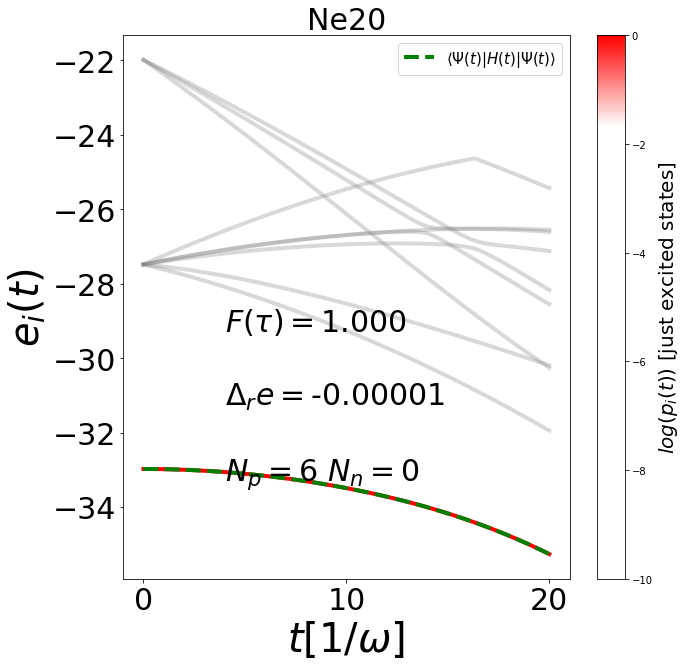

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


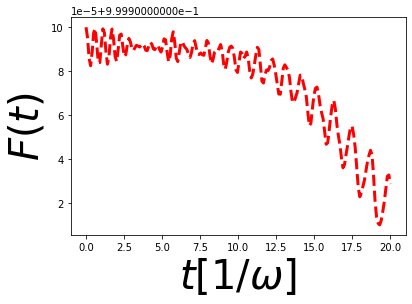

In [25]:
levels_studied=10
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_red', [(1, 0, 0, -5), (1, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))

print(eng_t.shape)
plt.figure(figsize=(10, 10))
print(probabilities[-1])
tot_scatters=[]

probs=np.log10(probabilities[:levels_studied]+10**-10)

print(probabilities[1])
norm = plt.Normalize(probs.min(), probs.max())
for i in range(0,levels_studied):
    
    if i==0:
        plt.plot(time, spectrum[i],color='red',alpha=1,linewidth=4)
    else:
        plt.plot(time, spectrum[i],color='grey',alpha=0.3,linewidth=4)
    
    
plt.plot(time, eng_t,color='green',linestyle='--',linewidth=4,label=r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$')

for i in range(0,levels_studied):
    if i!=0:
        plt.scatter(time, spectrum[i],c=probs[i],cmap=cmap,norm=norm,s=10)
        # if np.max(probs[i][:10])>-7 :
        #     plt.text(time[time.shape[0]//2], spectrum[i,-1], f'i={i}', color='black', fontsize=20,rotation=-45)
            #plt.scatter(time[time.shape[0]//2], spectrum[i,time.shape[0]//2+40],s=200)
#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)



#np.savez('data/quantum_annealing_results/Be8_results',time=time,average_unit_energy=average_unit_energy,spectrum=spectrum,fidelity=fidelity,probabilities=probabilities,energy=eng_t,fidelity_psi0=fidelity_psi0_t)


colorbar=plt.colorbar()
colorbar.set_label(r'$log(p_i(t))$ [just excited states]',fontsize=20)

# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$e_i(t)$',fontsize=40)
plt.text(x=tf*1/5,y=eng_t[-1]+6,s=r'$F(\tau)=$'+f'{fidelity.real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=eng_t[-1]+4, s=r"$\Delta_r e=$" + f"{(eng_t[-1].real-egs)/egs:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=eng_t[-1]+2,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/fig2')
plt.legend(fontsize=15, loc='upper right')
plt.title('Ne20',fontsize=30)
plt.show()




plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t [1/\omega]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/fig3')
plt.show()

#### Population plot

4.85451324663509


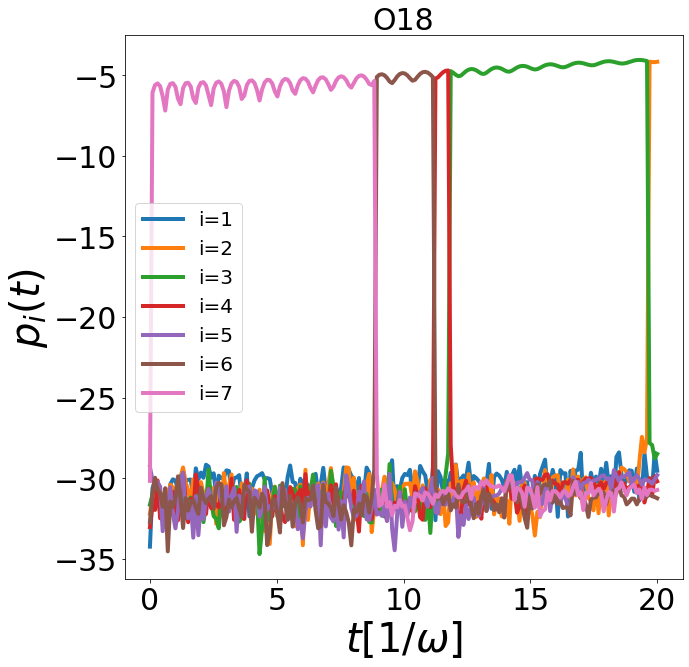

In [ ]:
plt.figure(figsize=(10,10))
for i in range(1,8):
    
    
    #if i==7 or i==6:
    plt.plot(time,np.log10(probabilities[i]),label=f'i={i}',linewidth=4)

plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=30)
plt.xlabel(r'$t [1/\omega]$',fontsize=40)
plt.ylabel(r'$p_i (t)$',fontsize=40)


print(np.min(spectrum[2]-spectrum[0]))

plt.title('Si30',fontsize=30)
plt.show()

#### $\tau$ vs Fidelity

In [ ]:
tfs = np.array([1,2,4,8,16,32,64])/average_unit_energy
nsteps =10*tfs
nlevels=1

#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
fidelities=[]
relative_err=[]
for a in range(tfs.shape[0]):
    tf=tfs[a]
    nstep=int(nsteps[a])
    time = np.linspace(0.0, tf, nstep)
    psi = psi_initial
    dt=time[1]-time[0]
    lambd=1-time/tf
    for i in trange(nstep):

        time_hamiltonian = (
            InitialHamiltonian.hamiltonian * ( lambd[i])
            + TargetHamiltonian.hamiltonian * (1-lambd[i])
        ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
        values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
        e_square_ave = (
            psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
        )
        
    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1

    print('fidelity=',degenerate_fidelity,'relative energy error=',np.abs((egs-e_ave)/egs),'\n')
    fidelities.append(degenerate_fidelity)
    relative_err.append(np.abs((egs-e_ave)/egs))    


fidelities=np.asarray(fidelities)
relative_err=np.asarray(relative_err)


#### Plots

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
ax.plot(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',linewidth=4,linestyle='-')
ax.scatter(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',s=100)
ax.semilogy()
ax.set_xlabel(r'$\tau \omega $',fontsize=40)
ax.set_ylabel(r'$1-F$',fontsize=40)
ax_twin=ax.twinx()
ax_twin.plot(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',linewidth=4,linestyle='--')
ax_twin.scatter(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',s=100)
ax.legend(fontsize=30)
ax_twin.semilogy()
ax_twin.legend(fontsize=30,loc='lower left')
ax_twin.set_ylabel('$|\Delta_r e|$',fontsize=40)
ax.tick_params(which='major',labelsize=30)
ax_twin.tick_params(which='major',labelsize=30)
plt.show()

#### Silicon Analysis

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data=np.load('data/quantum_annealing_results/silicon_results_quantum_annealing.npz')

nparticles_a=6
nparticles_b=6
fidelity=data['fidelity']
spectrum=data['spectrum']
eng_t=data['energy']
probabilities=data['probabilities']
egs=data['egs']
time=np.linspace(0,10/average_unit_energy,eng_t.shape[0])
tf=10/average_unit_energy
for i in range(spectrum.shape[0]):
    plt.plot(spectrum[i])
plt.plot(eng_t)
plt.show()

NameError: name 'average_unit_energy' is not defined

In [3]:
levels_studied=2
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_black', [(0, 0, 0, 0), (0, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))

print(eng_t.shape,egs.shape)
plt.figure(figsize=(10, 10))
print(probabilities[-1])
tot_scatters=[]

probs=probabilities[:levels_studied]

print(probabilities[1])
norm = plt.Normalize(probabilities.min(), probabilities.max())
for i in range(0,levels_studied):
    plt.plot(time, spectrum[i],color='red')

for i in range(0,levels_studied):
    plt.scatter(time, spectrum[i],c=probabilities[i],cmap=cmap,norm=norm,s=20)

#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

colorbar=plt.colorbar()
colorbar.set_label('Population',fontsize=20)

print(fidelity.shape)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*1/5,y=eng_t[-1]+9,s=r'$F(\tau)=$'+f'{fidelity[-1].real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=eng_t[-1]+6, s=r"$\Delta_r e=$" + f"{(eng_t[-1].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=eng_t[-1]+3,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/fig2')
plt.show()

NameError: name 'eng_t' is not defined

<Figure size 720x720 with 0 Axes>

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


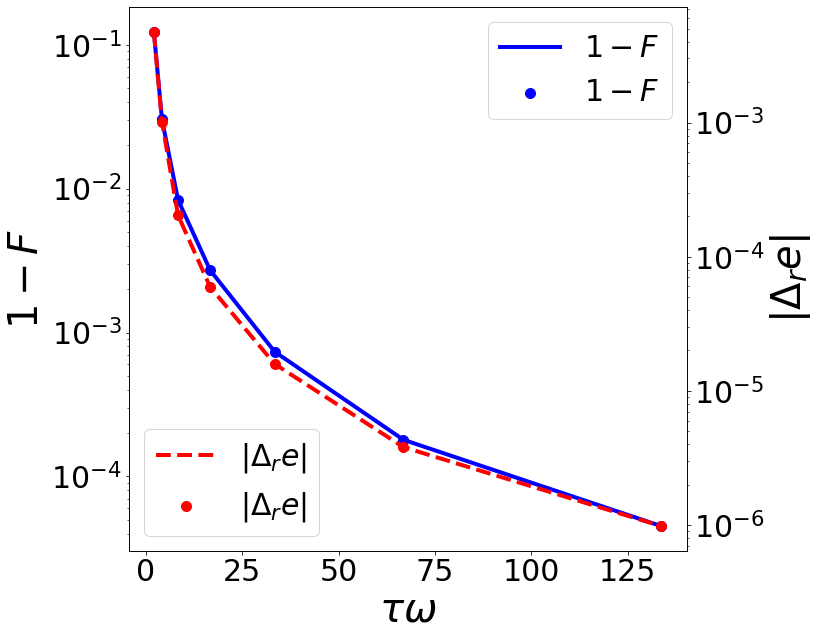

In [4]:
data=np.load('data/quantum_annealing_results/silicon_qa_results_fidelity_tau.npz')

fidelities=data['fidelity']
tfs=data['tau']
relative_err=data['relative_error']


fig,ax=plt.subplots(figsize=(10,10))
ax.plot(tfs,1-fidelities,label=r'$1-F$',color='blue',linewidth=4,linestyle='-')
ax.scatter(tfs,1-fidelities,label=r'$1-F$',color='blue',s=100)
ax.semilogy()
ax.set_xlabel(r'$\tau \omega $',fontsize=40)
ax.set_ylabel(r'$1-F$',fontsize=40)
ax_twin=ax.twinx()
ax_twin.plot(tfs,relative_err,label=r'$|\Delta_r e|$',color='red',linewidth=4,linestyle='--')
ax_twin.scatter(tfs,relative_err,label=r'$|\Delta_r e|$',color='red',s=100)
ax.legend(fontsize=30)
ax_twin.semilogy()
ax_twin.legend(fontsize=30,loc='lower left')
ax_twin.set_ylabel('$|\Delta_r e|$',fontsize=40)
ax.tick_params(which='major',labelsize=30)
ax_twin.tick_params(which='major',labelsize=30)
plt.show()

#### Plot 1 of the result section

In [12]:
data_ne22=np.load('data/quantum_annealing_results/Ne22_results.npz')

fidelity_ne22=data_ne22['fidelity']
probabilities_ne22=data_ne22['probabilities']
energy_ne22=data_ne22['energy']
spectrum_ne22=data_ne22['spectrum']
average_unit_energy_ne22=data_ne22['average_unit_energy']
fidelity_gs_ne22=data_ne22['fidelity_psi0']
time_ne22=np.linspace(0,10/average_unit_energy_ne22,100)
egs_ne22=spectrum_ne22[0,-1]


data_be8=np.load('data/quantum_annealing_results/Be8_results.npz')
fidelity_be8=data_be8['fidelity']
probabilities_be8=data_be8['probabilities']
energy_be8=data_be8['energy']
spectrum_be8=data_be8['spectrum']
average_unit_energy_be8=data_be8['average_unit_energy']
fidelity_gs_be8=data_be8['fidelity_psi0']
time_be8=data_be8['time']
egs_be8=spectrum_be8[0,-1]
print(spectrum_be8.shape)


data_si=np.load('data/quantum_annealing_results/silicon_results_quantum_annealing.npz')
fidelity_si=data_si['fidelity']
probabilities_si=data_si['probabilities']
energy_si=data_si['energy']
spectrum_si=data_si['spectrum']
fidelity_gs_si=data_si['fidelity_psi0']
time_si=np.linspace(0,20,200)
egs_si=data_si['egs']


(10, 200)


Non adiabatic transitions in the Si28

(200,) (200,) (1,)
(10, 200)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


<Figure size 720x720 with 0 Axes>

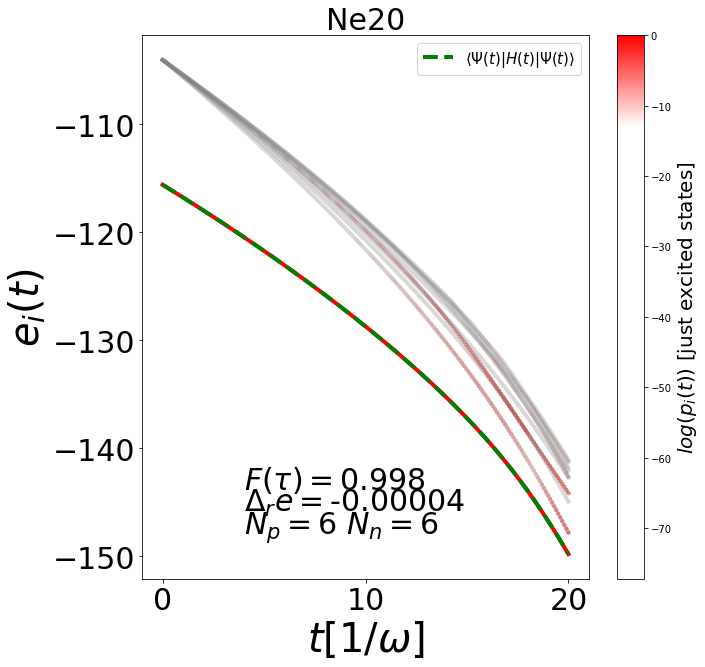

ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 720x720 with 1 Axes>

In [13]:
levels_studied=10
nparticles_a=6
nparticles_b=6
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_red', [(1, 0, 0, -5), (1, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))
print(fidelity_si.shape,energy_si.shape,egs_si.shape)
tf=time_si[-1]
plt.figure(figsize=(10, 10))
print(probabilities_si.shape)
tot_scatters=[]

probs=np.log(probabilities_si[:levels_studied])

norm = plt.Normalize(probs.min(), probs.max())
for i in range(0,levels_studied):
    
    if i==0:
        plt.plot(time_si, spectrum_si[i],color='red',alpha=1,linewidth=4)
    else:
        plt.plot(time_si, spectrum_si[i],color='grey',alpha=0.3,linewidth=4)
    
    
plt.plot(time_si, energy_si,color='green',linestyle='--',linewidth=4,label=r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$')

for i in range(0,levels_studied):
    if i!=0:
        plt.scatter(time_si, spectrum_si[i],c=probs[i],cmap=cmap,norm=norm,s=10)
        # if np.max(probs[i][:10])>-7 :
        #     plt.text(time[time.shape[0]//2], spectrum[i,-1], f'i={i}', color='black', fontsize=20,rotation=-45)
            #plt.scatter(time[time.shape[0]//2], spectrum[i,time.shape[0]//2+40],s=200)
#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)



#np.savez('data/quantum_annealing_results/Be8_results',time=time,average_unit_energy=average_unit_energy,spectrum=spectrum,fidelity=fidelity,probabilities=probabilities,energy=eng_t,fidelity_psi0=fidelity_psi0_t)


colorbar=plt.colorbar()
colorbar.set_label(r'$log(p_i(t))$ [just excited states]',fontsize=20)

# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$e_i(t)$',fontsize=40)
plt.text(x=tf*1/5,y=energy_si[-1]+6,s=r'$F(\tau)=$'+f'{fidelity_si[-1].real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=energy_si[-1]+4, s=r"$\Delta_r e=$" + f"{(energy_si[-1].real-egs_si[0])/egs_si[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=energy_si[-1]+2,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/fig2')
plt.legend(fontsize=15, loc='upper right')
plt.title('Ne20',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$$',fontsize=40)
for i in range(1,10):
    #if i==7 or i==1:
    plt.plot(time_si,probs[i],label=f'i={i}')
plt.legend(fontsize=20)
plt.show()

Plot for the paper

We need to use a colormap in a fancy way!

(200,)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(200,)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(200,)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


FIDELITY= (0.998050562985638+0j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


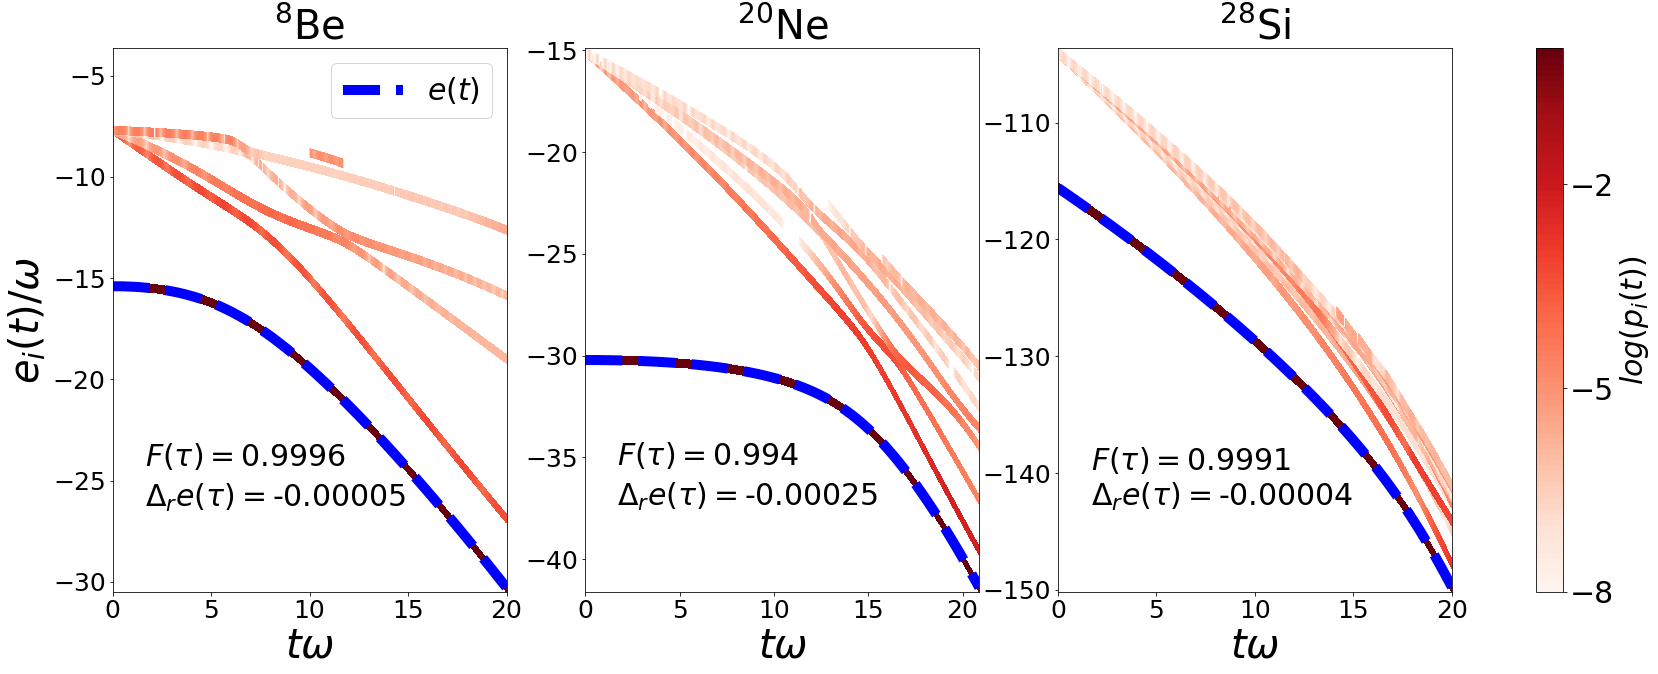

In [16]:
from matplotlib.colors import LinearSegmentedColormap
cmap = cmap = LinearSegmentedColormap.from_list(
    'blue_to_red',
    [(0, 0, 1),  # Blue (RGB)
     (1, 0, 0)]  # Red (RGB)
)
#plt.rc('text', usetex=True)

#plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mathptmx} ')
plt.rc('text.latex', preamble=r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \renewcommand{\rmdefault}{cmr} % Ensure Computer Modern Roman
    \renewcommand{\sfdefault}{cmss} % Ensure Computer Modern Sans Serif
    \renewcommand{\ttdefault}{cmtt} % Ensure Computer Modern Typewriter
''')
vmax=0
vmin=-8
fig,ax=plt.subplots(1,3,figsize=(30,10))

levels_studied=probabilities_be8.shape[0]
probs=np.log10(probabilities_be8[:levels_studied]+10**-10)
print(time_be8.shape)

norm = plt.Normalize(-10, 0)

#ax[0].plot(time_be8, spectrum_be8[0],color='red',linewidth=8)
ax[0].plot(time_be8, energy_be8,color='blue',linewidth=10,linestyle='--',label=r'$e(t)$')

#for i in range(0,levels_studied):
#    ax[0].plot(time_be8, spectrum_be8[i],color='grey',linewidth=1)

scatters = []
for i in range(0,levels_studied):
    dy_plus=spectrum_be8[i]+0.2
    dy_minus=spectrum_be8[i]-0.2
    y_2d=np.zeros((dy_plus.shape[0],10))
    x_2d=np.zeros((dy_plus.shape[0],10))
    prob_2d=np.zeros((dy_plus.shape[0],10))
    for r in range(dy_plus.shape[0]):
        y_2d[r,:]=np.linspace(dy_minus[r],dy_plus[r],10)
        x_2d[r]=time_be8[r]
        if probs[i,r]<-15:
            prob_2d[r]=-15
        else:
            prob_2d[r]=probs[i,r]
    #ax[2].plot(time_si, spectrum_si[i],color='grey',linewidth=1)
    levels = np.linspace(vmin, vmax, 100)
    contourt=ax[0].contourf(x_2d, y_2d, prob_2d,cmap='Reds',levels=levels,vmin=vmin, vmax=vmax)
#gs_scatter=plt.scatter(time,eng_t[:],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)


# plt.xlim([0.9,1])
ax[0].set_xlabel(r'$t \omega$',fontsize=40)
ax[0].set_ylabel(r'$e_i(t)/ \omega$',fontsize=40)
ax[0].text(x=10*1/6,y=energy_be8[-1]+6,s=r'$F(\tau)=$'+f'{fidelity_be8.real:.4f}',fontsize=30)
ax[0].text(x=10 * 1 / 6, y=energy_be8[-1]+4, s=r"$\Delta_r e(\tau)=$" + f"{(energy_be8[-1].real-egs_be8)/egs_be8:.5f}", fontsize=30)

# ax[0].text(
#     x=10 * 1 / 6,
#     y=energy_be8[-1]+1,
#     s=r"$^{8}$Be",
#     fontsize=30,
# )

ax[0].set_title(r'$^{8}$Be',fontsize=40)


#ax[0].text(x=5,y=-21,s=r'$^{8}$Be',fontsize=40)
ax[0].legend(fontsize=30,loc='upper right')

# cbar = fig.colorbar(scatters[0], ax=ax[0], orientation='vertical')
# cbar.set_label('Population', fontsize=20)

levels_studied=probabilities_ne22.shape[0]
probs=np.log10(probabilities_ne22[:levels_studied]+10**-10)
print(time_be8.shape)

norm = plt.Normalize(-10, 0)

#ax[1].plot(time_ne22, spectrum_ne22[0],color='red',linewidth=8)
ax[1].plot(time_ne22, energy_ne22,color='blue',linewidth=10,linestyle='--',label=r'$e(t)$')

#for i in range(0,levels_studied):
#    ax[1].plot(time_ne22, spectrum_ne22[i],color='grey',linewidth=1)

scatters = []
for i in range(0,levels_studied):
    dy_plus=spectrum_ne22[i]+0.2
    dy_minus=spectrum_ne22[i]-0.2
    y_2d=np.zeros((dy_plus.shape[0],10))
    x_2d=np.zeros((dy_plus.shape[0],10))
    prob_2d=np.zeros((dy_plus.shape[0],10))
    for r in range(dy_plus.shape[0]):
        y_2d[r,:]=np.linspace(dy_minus[r],dy_plus[r],10)
        x_2d[r]=time_ne22[r]
        if probs[i,r]<-15:
            prob_2d[r]=-15
        else:
            prob_2d[r]=probs[i,r]
    #ax[2].plot(time_si, spectrum_si[i],color='grey',linewidth=1)
    levels = np.linspace(vmin, vmax, 100)
    contourt=ax[1].contourf(x_2d, y_2d, prob_2d,cmap='Reds',levels=levels,vmin=vmin, vmax=vmax)
#gs_scatter=plt.scatter(time,eng_t[:],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

# plt.xlim([1.9,1])
ax[1].set_xlabel(r'$t \omega$',fontsize=40)
#ax[1].set_ylabel(r'$e_i(t)$',fontsize=40)
ax[1].text(x=10*1/6,y=energy_ne22[-1]+6,s=r'$F(\tau)=$'+f'{fidelity_ne22.real:.3f}',fontsize=30)
ax[1].text(x=10 * 1 / 6, y=energy_ne22[-1]+4, s=r"$\Delta_r e (\tau)=$" + f"{(energy_ne22[-1].real-egs_ne22)/egs_ne22:.5f}", fontsize=30)
#ax[1].legend(fontsize=30)

# ax[1].text(
#     x=10 * 1 / 6,
#     y=energy_ne22[-1]+1,
#     s=r"$^{20}$Ne",
#     fontsize=30,
# )

ax[1].set_title(r'$^{20}$Ne',fontsize=40)

#ax[1].text(x=5,y=-25,s=r'$^{20}$Ne',fontsize=40)
# cbar = fig.colorbar(scatters[1], ax=ax[1], orientation='vertical')
# cbar.set_label('Population', fontsize=20)


levels_studied=probabilities_si.shape[0]
probs=np.log10(probabilities_si[:levels_studied]+10**-10)
print(time_be8.shape)
norm = plt.Normalize(-10, 0)



#ax[2].plot(time_si, spectrum_si[0],color='red',linewidth=8)
ax[2].plot(time_si, energy_si,color='blue',linewidth=10,linestyle='--',label=r'$e(t)$')
#ax[2].set_ylabel(r'$e_i(t)$',fontsize=40)
ax[2].set_xlabel(r'$t \omega$',fontsize=40)
for i in range(0,levels_studied):
    dy_plus=spectrum_si[i]+0.4
    dy_minus=spectrum_si[i]-0.4
    y_2d=np.zeros((dy_plus.shape[0],10))
    x_2d=np.zeros((dy_plus.shape[0],10))
    prob_2d=np.zeros((dy_plus.shape[0],10))
    for r in range(dy_plus.shape[0]):
        y_2d[r,:]=np.linspace(dy_minus[r],dy_plus[r],10)
        x_2d[r]=time_si[r]
        if probs[i,r]<-15:
            prob_2d[r]=-15
        else:
            prob_2d[r]=probs[i,r]
    #ax[2].plot(time_si, spectrum_si[i],color='grey',linewidth=1)
    levels = np.linspace(vmin, vmax, 100)
    contourt=ax[2].contourf(x_2d, y_2d, prob_2d,cmap='Reds',levels=levels,vmin=vmin, vmax=vmax)

scatters = []
#for i in range(0,levels_studied):
#    scatter = ax[2].scatter(time_si , spectrum_si[i], c=probs[i], cmap=cmap, norm=norm, s=30)
#    scatters.append(scatter)
#gs_scatter=plt.scatter(time,eng_t[:],c=probabilities[1,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

print('FIDELITY=',fidelity_si[-1])
# plt.xlim([1.9,1])
ax[2].set_xlabel(r'$t \omega$',fontsize=40)
#ax[2].set_ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
ax[2].text(x=10*1/6,y=energy_si[-1]+9+1,s=r'$F(\tau)=$'+f'{0.9991}',fontsize=30)
ax[2].text(x=10 * 1 / 6, y=energy_si[-1]+6+1, s=r"$\Delta_r e(\tau)=$" + f"{(energy_si[-1].real-egs_si[0])/egs_si[0]:.5f}", fontsize=30)
#ax[2].legend(fontsize=30)

# ax[2].text(
#     x=10 * 1 / 6,
#     y=energy_si[-1]+2,
#     s=r"$^{28}$Si",
#     fontsize=30,
# )

ax[2].set_title(r'$^{28}$Si',fontsize=40)

for i in range(3):
    ax[i].tick_params(which='major',labelsize=25)
    ax[i].tick_params(which="minor", labelsize=25)

cbar = plt.colorbar(contourt, ax=ax, orientation='vertical', pad=0.05) 
cbar.ax.tick_params(labelsize=30)
cbar.set_label(r'$log(p_i(t))$', fontsize=30)
#ax[2].text(x=8,y=-109,s=r'$^{28}$Si',fontsize=40)
cbar.set_ticks(np.arange(vmin, vmax+1, 3))

plt.savefig("images/fig1", format="pdf", bbox_inches="tight")
plt.show()

Fidelity evolutions

(200,)
[8.83698497e-01+0.j 8.83056702e-01+0.j 8.80847447e-01+0.j
 8.76980511e-01+0.j 8.72216688e-01+0.j 8.67754278e-01+0.j
 8.64592340e-01+0.j 8.63001546e-01+0.j 8.62397145e-01+0.j
 8.61668700e-01+0.j 8.59753321e-01+0.j 8.56145933e-01+0.j
 8.51122921e-01+0.j 8.45596047e-01+0.j 8.40663526e-01+0.j
 8.37075410e-01+0.j 8.34892708e-01+0.j 8.33505257e-01+0.j
 8.31954425e-01+0.j 8.29362937e-01+0.j 8.25280831e-01+0.j
 8.19836088e-01+0.j 8.13652273e-01+0.j 8.07571413e-01+0.j
 8.02305519e-01+0.j 7.98175082e-01+0.j 7.95032779e-01+0.j
 7.92365437e-01+0.j 7.89500849e-01+0.j 7.85836316e-01+0.j
 7.81017999e-01+0.j 7.75021258e-01+0.j 7.68124244e-01+0.j
 7.60812557e-01+0.j 7.53659980e-01+0.j 7.47198386e-01+0.j
 7.41771775e-01+0.j 7.37398916e-01+0.j 7.33711492e-01+0.j
 7.30029705e-01+0.j 7.25574672e-01+0.j 7.19743486e-01+0.j
 7.12337681e-01+0.j 7.03651409e-01+0.j 6.94378272e-01+0.j
 6.85367372e-01+0.j 6.77325144e-01+0.j 6.70585091e-01+0.j
 6.65031092e-01+0.j 6.60182434e-01+0.j 6.55381203e-01+0.j
 6.4999

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


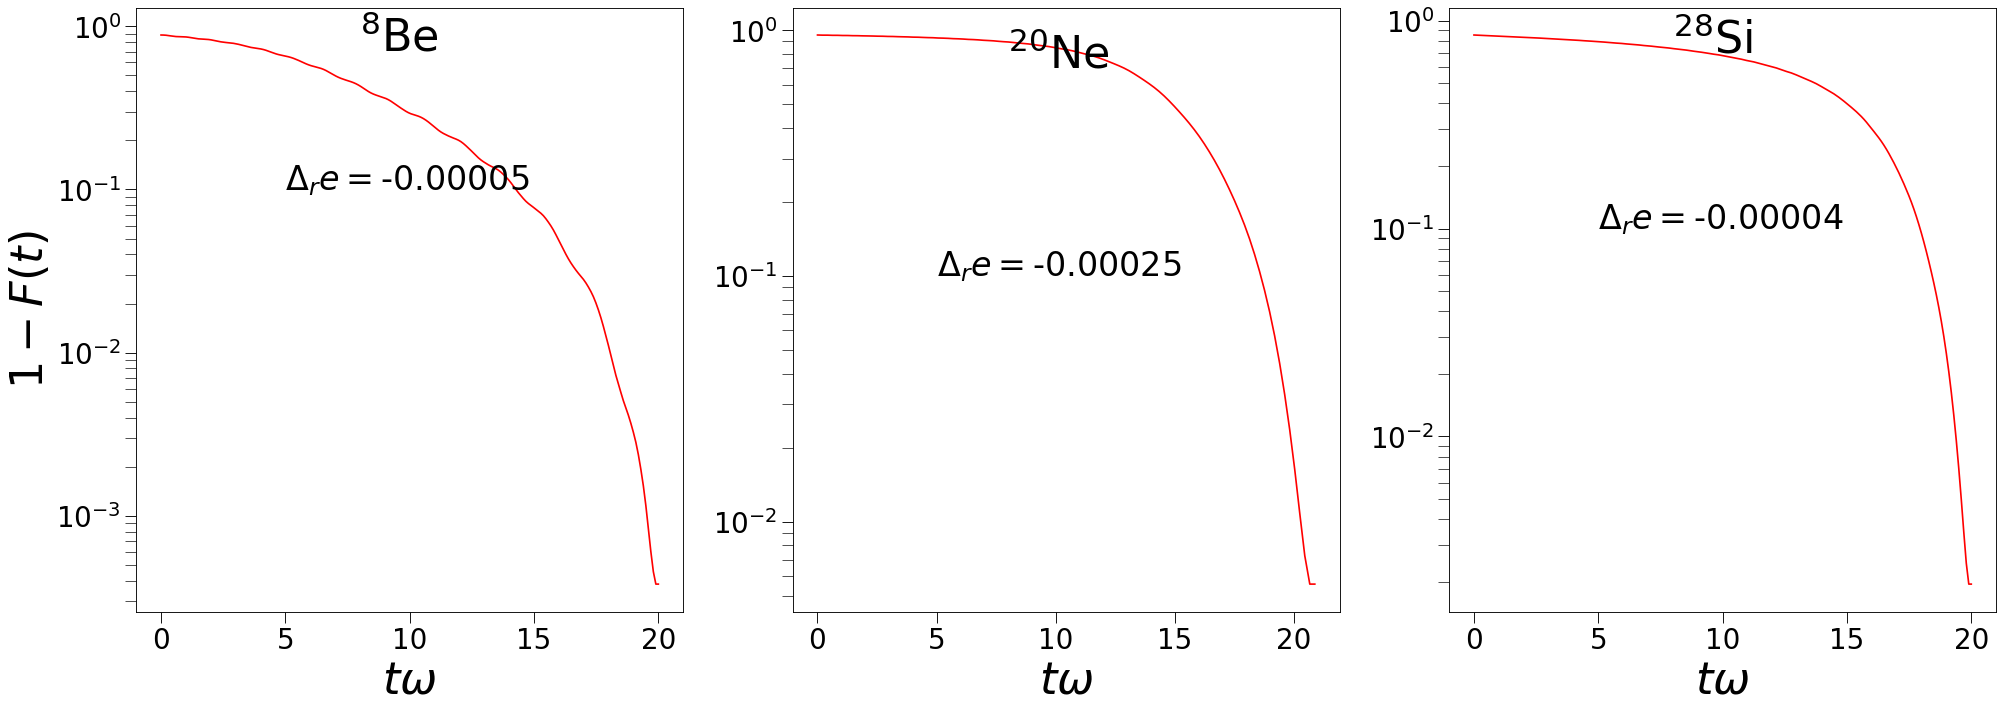

In [23]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(1, 3, figsize=(30, 10), dpi=80)
print(fidelity_gs_be8.shape)
print(1-fidelity_gs_be8)
ax[0].plot(time_be8,1-fidelity_gs_be8,color='red')


#gs_scatter=plt.scatter(time,eng_t[:],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)


# plt.xlim([0.9,1])
ax[0].set_xlabel(r'$t \omega$',fontsize=40)
ax[0].set_ylabel(r'$1-F(t)$',fontsize=40)
#ax[0].text(x=5,y=energy_be8[-1]+6,s=r'$F(\tau)=$'+f'{fidelity_be8.real:.3f}',fontsize=30)
ax[0].text(x=5, y=0.1, s=r"$\Delta_r e=$" + f"{(energy_be8[-1].real-egs_be8)/egs_be8:.5f}", fontsize=30)

# ax[0].text(
#     x=10 * 1 / 6,
#     y=energy_be8[-1]+2,
#     s=r"$N_p=$" + f"{2} " + r"$N_n=$" + f"{2}",
#     fontsize=30,
# )

ax[0].text(x=8,y=0.7,s=r'$^8$Be',fontsize=40)


# cbar = fig.colorbar(scatters[0], ax=ax[0], orientation='vertical')
# cbar.set_label('Population', fontsize=20)

ax[1].plot(time_ne22, 1-fidelity_gs_ne22,color='red')


#gs_scatter=plt.scatter(time,eng_t[:],c=probabilities[1,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)


# plt.xlim([1.9,1])
ax[1].set_xlabel(r'$t \omega$',fontsize=40)
#ax[1].set_ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
# ax[1].text(x=10*1/6,y=energy_ne22[-1]+6,s=r'$F(\tau)=$'+f'{fidelity_ne22.real:.3f}',fontsize=30)
ax[1].text(x=5, y=0.1, s=r"$\Delta_r e=$" + f"{(energy_ne22[-1].real-egs_ne22)/egs_ne22:.5f}", fontsize=30)

# ax[1].text(
#     x=10 * 1 / 6,
#     y=energy_ne22[-1]+2,
#     s=r"$N_p=$" + f"{2} " + r"$N_n=$" + f"{2}",
#     fontsize=30,
# )

ax[1].text(x=8,y=0.7,s=r'$^{20}$Ne',fontsize=40)
# cbar = fig.colorbar(scatters[1], ax=ax[1], orientation='vertical')
# cbar.set_label('Population', fontsize=20)


print('FIDELITY SI=',fidelity_gs_si[-1])
ax[2].plot(time_si, 1-fidelity_gs_si,color='red')



# plt.xlim([1.9,1])
ax[2].set_xlabel(r'$t \omega$',fontsize=40)
#ax[2].set_ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
#ax[2].text(x=10,y=0.7,s=r'$F(\tau)=$'+f'{fidelity_si[-1].real:.3f}',fontsize=30)
ax[2].text(x=5, y=0.1, s=r"$\Delta_r e=$" + f"{(energy_si[-1].real-egs_si[0])/egs_si[0]:.5f}", fontsize=30)
ax[2].text(x=8, y=0.7, s=r'$^{28}$Si', fontsize=40)
# ax[2].text(
#     x=10 * 1 / 6,
#     y=energy_si[-1]+3,
#     s=r"$N_p=$" + f"{6} " + r"$N_n=$" + f"{6}",
#     fontsize=30,
# )
ax[0].semilogy()
ax[1].semilogy()
ax[2].semilogy()
for i in range(3):
    ax[i].tick_params(which='major',labelsize=25,length=5,size=10)
    ax[i].tick_params(which="minor", labelsize=25,length=10,size=10)


plt.show()

0.005517145591118164
1.8564677902452276e-05
4.207836100942593e-06
1.8516220679966952e-05
5.152440572017941e-08
9.572400986349324e-08
1e-10
1.0096464659333047e-06
1e-10


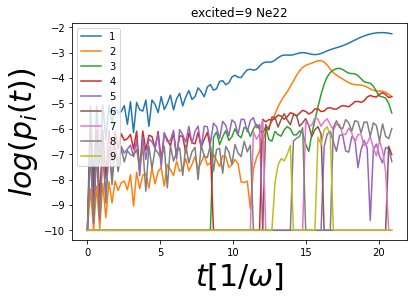

0.0013458742387304457
3.3436765655122926e-07
0.0005600898875917419
9.289643670121356e-08
2.3303652913890095e-05
4.2141151739744476e-07
5.7603174667612376e-08
4.361779457673173e-06
8.670115161035992e-07


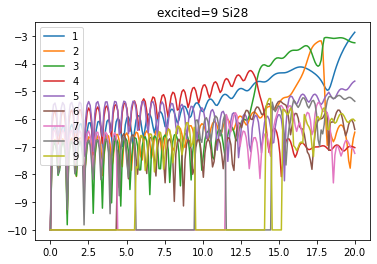

(10, 200)
5.292894534472964


In [16]:
for i in range(1,10):
    plt.title(f'excited={i} Ne22')
    plt.plot(time_ne22,np.log10(probabilities_ne22[i]+10**-10),label=i)
    print((probabilities_ne22[i]+10**-10)[-1])
plt.xlabel(r'$t[1/\omega]$',fontsize=30)
plt.ylabel(r'$log(p_i(t))$',fontsize=30)

plt.legend()
plt.show()

for i in range(1,10):
    plt.title(f'excited={i} Si28')
    plt.plot(time_si,np.log10(probabilities_si[i]+10**-10),label=i)
    print((probabilities_si[i]+10**-10)[-1])
plt.legend()
plt.show()
# for i in range(1,10):
#     plt.title(f'excited={i} Be8')
#     plt.plot(time_be8,np.log10(probabilities_be8[i]+10**-10))
#     plt.show()

print(spectrum_si.shape)
print(np.min(spectrum_si[3]-spectrum_si[0]))

#### Plot 2 result section

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

[(0.0011818704634656285+0j), (0.0006201498587881105+0j), (0.0013345542133008648+0j), (7.368022985110301e-05+0j)]
[(0.0003820073347190478+0j), (0.00024105964093512622+0j), (0.0005268942095169038+0j), (2.1160068772063667e-05+0j)]
[(4.217103389159149e-05+0j), (9.976224040453285e-05+0j), (0.0002026466092902579+0j), (6.926823277186855e-07+0j)]


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


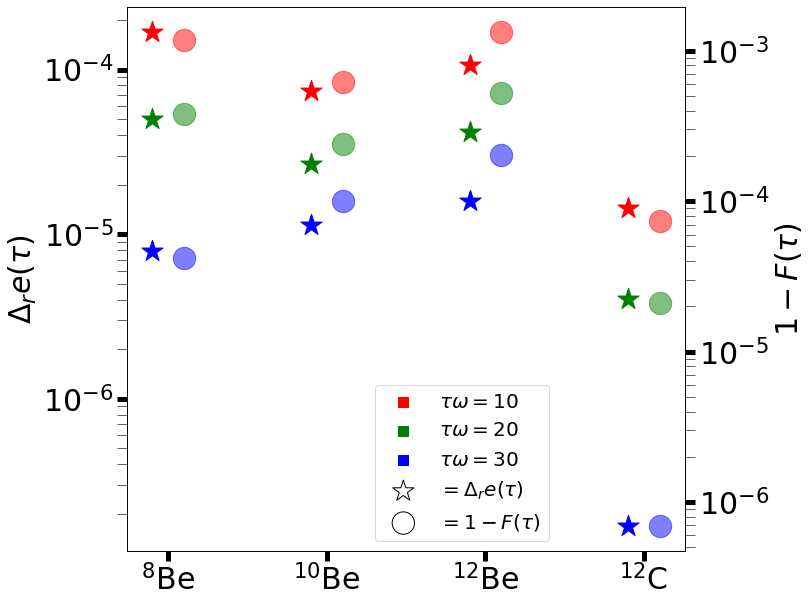

In [33]:
data=np.load('data/quantum_annealing_results/plot_results_fig2.npz')

fidelity=data['fidelity']
nparticles=data['particles']
labels=data['labels']
errors=data['errors']
labels=[r'$^{8}$Be',r'$^{10}$Be',r'$^{12}$Be',r'$^{12}$C']
titles=[r'$\tau \omega=10$',r'$\tau \omega=20$',r'$\tau \omega=30$']
colors=['red','green','blue']
fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
for j in range(errors[0].shape[0]): 
    errors_per_label=[errors[i][j] for i in range(len(errors))]
    fidelity_per_label=[1-fidelity[i][j] for i in range(len(errors))]
    print(fidelity_per_label)

    if j==0:
        ax.scatter(np.arange(len(labels))-0.1,errors_per_label,marker='*',s=500,color=colors[j])
        ax_twin.scatter(np.arange(len(labels))+0.1,fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    else:
        ax.scatter(np.arange(len(labels))-0.1,errors_per_label,marker='*',s=500,color=colors[j])
        ax_twin.scatter(np.arange(len(labels))+0.1,fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    #plt.plot(np.arange(len(labels)),errors_per_label,label=titles[j])
    #ax.plot(np.arange(len(labels)),errors_per_label,label=titles[j],color=colors[j])
        
    ax.set_xticks(np.arange(len(labels)),labels)
    ax.set_ylabel(r'$\Delta_r e(\tau)$',fontsize=30)
    ax_twin.set_ylabel(r'$1-F(\tau)$',fontsize=30)
    
ax.semilogy()


ax.scatter([],[],marker='s',color='red',s=100,label=r'$\tau\omega=10$')
ax.scatter([],[],marker='s',color='green',s=100,label=r'$\tau\omega=20$')
ax.scatter([],[],marker='s',color='blue',s=100,label=r'$\tau\omega=30$')
ax.scatter([],[],marker='*',facecolors='none', edgecolors='black',s=500,label=r'$=\Delta_r e (\tau)$')
ax.scatter([],[],marker='o',facecolors='none', edgecolors='black',s=500,label=r'$=1-F (\tau)$')
ax.legend(fontsize=20,loc='lower center',bbox_to_anchor=(0.6, 0.))
#ax.legend(fontsize=20,loc='lower right')

# ax.scatter([1],[7*10**-6],marker='*',color='black',s=800)
# ax.text(1.1,6.5*10**-6,s=r'$=\Delta_r e(\tau)$',fontsize=30)

# ax.scatter([1],[5*10**-6],marker='o',color='black',s=800)
# ax.text(1.1,4.5*10**-6,s=r'$=1-F(\tau)$',fontsize=30)

# x_start, y_start = 0.8, 4*10**-6   # Bottom-left corner of the rectangle
# width, height = 1.3, 5*10**-6     # Width and height of the rectangle

# # Create the rectangle
# rect = Rectangle((x_start, y_start), width, height,
#                  edgecolor='black', facecolor='none', linestyle='--', linewidth=2)

# ax.add_patch(rect)

ax_twin.semilogy()
ax.tick_params(which='major',labelsize=30,width=5,length=10) 
ax_twin.tick_params(which='major',labelsize=30,width=5,length=10) 
ax.tick_params(which='minor',labelsize=30,length=10) 
ax_twin.tick_params(which='minor',labelsize=30,length=10) 
plt.savefig("images/fig3", format="pdf", bbox_inches="tight")
plt.show()

    

[(0.017931754731123184+0j), (0.0194049119187113+0j), (0.026153236363179233+0j), (0.0024362294232974646+0j)]
[(0.0017808310981477504+0j), (0.0022550570267121373+0j), (0.003814977550410603+0j), (0.0006229492703735406+0j)]
[(0.0008183168229511928+0j), (0.001104107235862184+0j), (0.0016554174151918177+0j), (0.00027626778252254347+0j)]


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


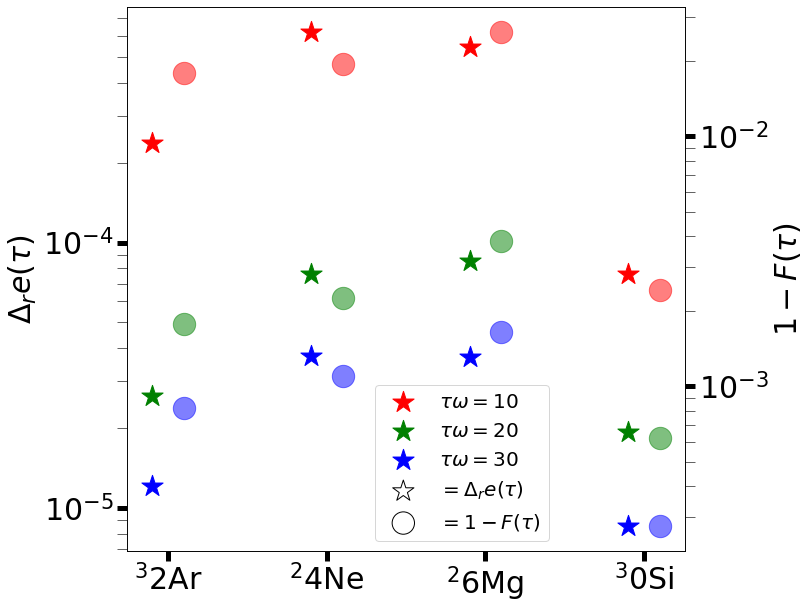

In [24]:
data=np.load('data/quantum_annealing_results/plot_results_fig2_other_heavy_nuclei.npz')

fidelity=data['fidelity']
nparticles=data['particles']
labels=data['labels']
errors=data['errors']
labels=[r'$^32$Ar',r'$^24$Ne',r'$^26$Mg',r'$^30$Si']
titles=[r'$\tau \omega=10$',r'$\tau \omega=20$',r'$\tau \omega=30$']
colors=['red','green','blue']
fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
for j in range(errors[0].shape[0]): 
    errors_per_label=[errors[i][j] for i in range(len(errors))]
    fidelity_per_label=[1-fidelity[i][j] for i in range(len(errors))]
    print(fidelity_per_label)

    if j==0:
        ax.scatter(np.arange(len(labels))-0.1,errors_per_label,label=titles[j],marker='*',s=500,color=colors[j])
        ax_twin.scatter(np.arange(len(labels))+0.1,fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    else:
        ax.scatter(np.arange(len(labels))-0.1,errors_per_label,marker='*',label=titles[j],s=500,color=colors[j])
        ax_twin.scatter(np.arange(len(labels))+0.1,fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    #plt.plot(np.arange(len(labels)),errors_per_label,label=titles[j])
    #ax.plot(np.arange(len(labels)),errors_per_label,label=titles[j],color=colors[j])
        
    ax.set_xticks(np.arange(len(labels)),labels)
    ax.set_ylabel(r'$\Delta_r e(\tau)$',fontsize=30)
    ax_twin.set_ylabel(r'$1-F(\tau)$',fontsize=30)
    
ax.semilogy()

ax.scatter([],[],marker='*',facecolors='none', edgecolors='black',s=500,label=r'$=\Delta_r e (\tau)$')
ax.scatter([],[],marker='o',facecolors='none', edgecolors='black',s=500,label=r'$=1-F (\tau)$')
ax.legend(fontsize=20,loc='lower center',bbox_to_anchor=(0.6, 0.))
#ax.legend(fontsize=20,loc='lower right')

# ax.scatter([1],[7*10**-6],marker='*',color='black',s=800)
# ax.text(1.1,6.5*10**-6,s=r'$=\Delta_r e(\tau)$',fontsize=30)

# ax.scatter([1],[5*10**-6],marker='o',color='black',s=800)
# ax.text(1.1,4.5*10**-6,s=r'$=1-F(\tau)$',fontsize=30)

# x_start, y_start = 0.8, 4*10**-6   # Bottom-left corner of the rectangle
# width, height = 1.3, 5*10**-6     # Width and height of the rectangle

# # Create the rectangle
# rect = Rectangle((x_start, y_start), width, height,
#                  edgecolor='black', facecolor='none', linestyle='--', linewidth=2)

# ax.add_patch(rect)

ax_twin.semilogy()
ax.tick_params(which='major',labelsize=30,width=5,length=10) 
ax_twin.tick_params(which='major',labelsize=30,width=5,length=10) 
ax.tick_params(which='minor',labelsize=30,length=10) 
ax_twin.tick_params(which='minor',labelsize=30,length=10) 
plt.savefig("images/fig4_bis", format="pdf", bbox_inches="tight")
plt.show()

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FIDELITY HEAVY NUCLEI= [[0.89805532+0.j 0.96808394+0.j 0.98714276+0.j]
 [0.92265004+0.j 0.97674587+0.j 0.99054465+0.j]
 [0.99636136+0.j 0.99916444+0.j 0.99960318+0.j]]
[(0.012195132863632052+0j), (0.05026850917744086+0j), (0.0002815457496645468+0j), (0.03374443492072032+0j), (0.10194467911269511+0j), (0.07734995838750414+0j), (0.0036386367477165837+0j), (0.017931754731123184+0j), (0.0194049119187113+0j), (0.026153236363179233+0j), (0.0024362294232974646+0j)]
[(0.0011337948610758986+0j), (0.00262530062064259+0j), (7.131692223905084e-05+0j), (0.006183203472393095+0j), (0.03191606053503726+0j), (0.023254130351188507+0j), (0.0008355597398324033+0j), (0.0017808310981477504+0j), (0.0022550570267121373+0j), (0.003814977550410603+0j), (0.0006229492703735406+0j)]
[(0.0006199117733463044+0j), (0.0012454508225641092+0j), (3.3687034044604935e-05+0j), (0.002529789096338164+0j), (0.0128572417360735+0j), (0.009455345361102707+0j), (0.00039681657775014756+0j), (0.0008183168229511928+0j), (0.0011041072

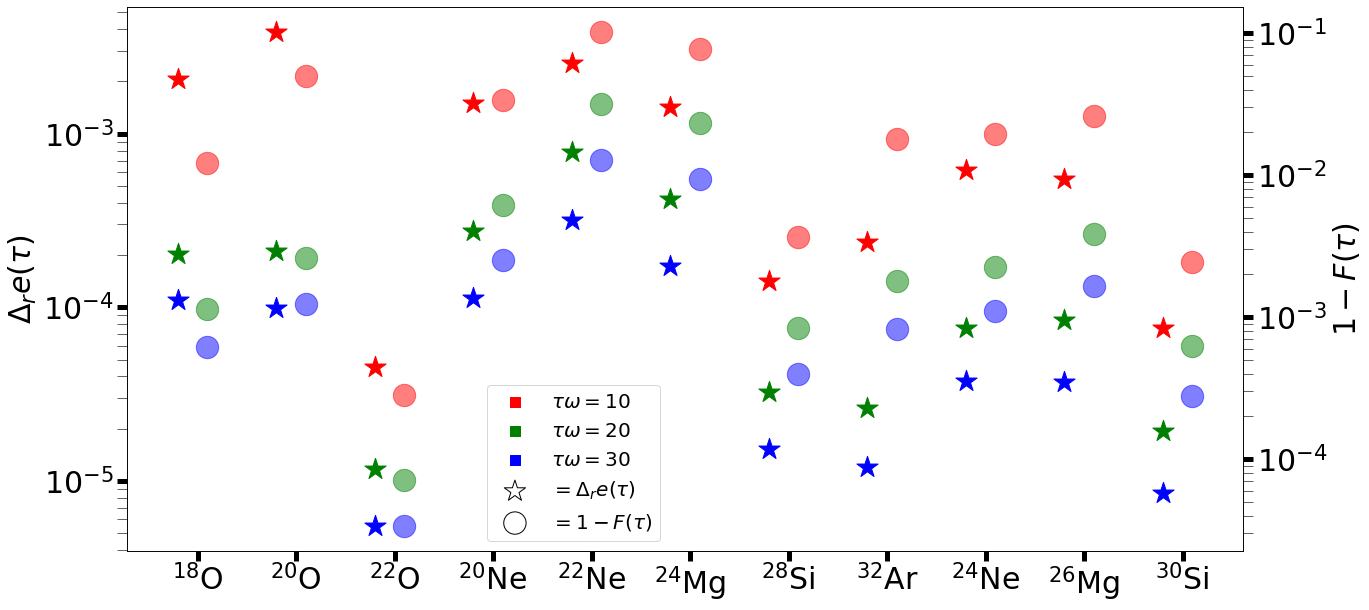

In [32]:
data=np.load('data/quantum_annealing_results/plot_results_fig2_usdb.npz')

fidelity=data['fidelity']
nparticles=data['particles']
labels=data['labels']
errors=data['errors']


data_2=np.load('data/quantum_annealing_results/plot_results_fig2_heavy_nuclei.npz')

fidelity_2=data_2['fidelity']
nparticles_2=data_2['particles']
labels_2=data_2['labels']
errors_2=data_2['errors']
labels=[r'$^{18}$O',r'$^{20}$O', r'$^{22}$O', r'$^{20}$Ne']


data_3=np.load('data/quantum_annealing_results/plot_results_fig2_other_heavy_nuclei.npz')

fidelity_3=data_3['fidelity']
nparticles_3=data_3['particles']
labels_3=data_3['labels']
errors_3=data_3['errors']
labels_3=[r'$^{32}$Ar',r'$^{24}$Ne',r'$^{26}$Mg',r'$^{30}$Si']

print('FIDELITY HEAVY NUCLEI=',fidelity_2)
labels_2=[r'$^{22}$Ne',r'$^{24}$Mg',r'$^{28}$Si']
titles=[r'$\tau \omega=10$',r'$\tau \omega=20$',r'$\tau \omega=30$']
colors=['red','green','blue']
fig,ax=plt.subplots(figsize=(20,10))
ax_twin=ax.twinx()
for j in range(errors[0].shape[0]): 
    errors_per_label=[errors[i][j] for i in range(len(errors))]+[errors_2[i][j] for i in range(len(errors_2))]+[errors_3[i][j] for i in range(len(errors_3))]
    fidelity_per_label=[1-fidelity[i][j] for i in range(len(errors))]+[1-fidelity_2[i][j] for i in range(len(errors_2))]+[1-fidelity_3[i][j] for i in range(len(errors_3))]
    print(fidelity_per_label)

    if j==0:
        ax.scatter(np.arange(len(labels)+len(labels_2)+len(labels_3))-0.2,errors_per_label,marker='*',s=500,color=colors[j])
        ax_twin.scatter(np.arange(len(labels)+len(labels_2)+len(labels_3))+0.1,fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    else:
        ax.scatter(np.arange(len(labels)+len(labels_2)+len(labels_3))-0.2,errors_per_label,marker='*',s=500,color=colors[j])
        ax_twin.scatter(np.arange(len(labels)+len(labels_2)+len(labels_3))+0.1,fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    #plt.plot(np.arange(len(labels)),errors_per_label,label=titles[j])
    #ax.plot(np.arange(len(labels)+len(labels_2)),errors_per_label,label=titles[j],color=colors[j])
        
ax.set_xticks(np.arange(len(labels)+len(labels_2)+len(labels_3)),labels+labels_2+labels_3)
ax.set_ylabel(r'$\Delta_r e (\tau)$',fontsize=30)
ax_twin.set_ylabel(r'$1-F (\tau)$',fontsize=30)
ax.legend(fontsize=20,loc='lower left')
    
# ax.scatter([3],[2*10**-5],marker='*',color='black',s=800)
# ax.text(3.1,1.8*10**-5,s=r'$=\Delta_r e(\tau)$',fontsize=30)

# ax.scatter([3],[1.1*10**-5],marker='o',color='black',s=800)
# ax.text(3.1,1.*10**-5,s=r'$=1-F(\tau)$',fontsize=30)

# x_start, y_start = 2.8, 8*10**-6   # Bottom-left corner of the rectangle
# width, height = 2.3, 2*10**-5     # Width and height of the rectangle

# # Create the rectangle
# rect = Rectangle((x_start, y_start), width, height,
#                  edgecolor='black', facecolor='none', linestyle='--', linewidth=2)

# ax.add_patch(rect)
ax.scatter([],[],marker='s',color='red',s=100,label=r'$\tau\omega=10$')
ax.scatter([],[],marker='s',color='green',s=100,label=r'$\tau\omega=20$')
ax.scatter([],[],marker='s',color='blue',s=100,label=r'$\tau\omega=30$')
ax.scatter([],[],marker='*',facecolors='none', edgecolors='black',s=500,label=r'$=\Delta_r e (\tau)$')
ax.scatter([],[],marker='o',facecolors='none', edgecolors='black',s=500,label=r'$=1-F (\tau)$')

ax.legend(fontsize=20,loc='lower center',bbox_to_anchor=(0.4, 0.))


ax.semilogy()
ax_twin.semilogy()
ax.tick_params(which='major',labelsize=30,width=5,length=10) 
ax_twin.tick_params(which='major',labelsize=30,width=5,length=10) 
ax.tick_params(which='minor',labelsize=30,length=10) 
ax_twin.tick_params(which='minor',labelsize=30,length=10) 
plt.savefig("images/fig4", format="pdf", bbox_inches="tight")
plt.show()

#### Plot 3 sections

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=np.load('data/quantum_annealing_results/different_states_quantum_annealing.npz')

fidelity=data['fidelity']
nparticles=data['particles']
labels=data['labels']
labels=[r'$|\tilde{s}\rangle$',r'$|s_1\rangle$',r'$|s_2\rangle$']
errors=data['errors']
print(errors.shape)
titles=[r'$^{20}$O',r'$^{24}$Mg']
colors=['red','green','blue']
fig,ax=plt.subplots(2,1,figsize=(10,20))
for j in range(len(errors)): 
    print(j)

    errors_per_label=errors[j]
    fidelity_per_label=1-fidelity[j]
    print(fidelity_per_label)
    ax[j].set_title(titles[j],fontsize=30)
    ax_twin=ax[j].twinx()
    
    ax[j].scatter(np.arange(len(errors_per_label)),errors_per_label,marker='*',s=500,color=colors[j])
    ax_twin.scatter(np.arange(len(errors_per_label)),fidelity_per_label,marker='o',s=500,color=colors[j],alpha=0.5)
    #plt.plot(np.arange(len(labels)),errors_per_label,label=titles[j])
    ax[j].plot(np.arange(len(labels)),errors_per_label,label=titles[j],color=colors[j])
        
    ax[j].set_xticks(np.arange(len(labels)),labels)
    ax[j].set_ylabel(r'$\Delta_r e$',fontsize=30)
    ax_twin.set_ylabel(r'$1-F$',fontsize=30)
    #ax[j].legend(fontsize=20,loc='upper center')
    ax[j].semilogy()
    ax_twin.semilogy()
    ax[j].tick_params(which='major',labelsize=30,width=5,length=10) 
    ax_twin.tick_params(which='major',labelsize=30,width=5,length=10) 
    ax[j].tick_params(which='minor',labelsize=30,length=10) 
    ax_twin.tick_params(which='minor',labelsize=30,length=10)
    
plt.show()

#### $\tau vs \Delta$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

[ 4.22020202  3.81818182  0.6020202   5.42626263  8.24040404 14.67272727
 27.93939394 36.38181818]
labels_cki= ['Be8' 'Be10' 'C12' 'Be12' 'Li8' 'B10' 'B6' 'B12']
(7,) (7,)
[-2.13321543  3.94315889]


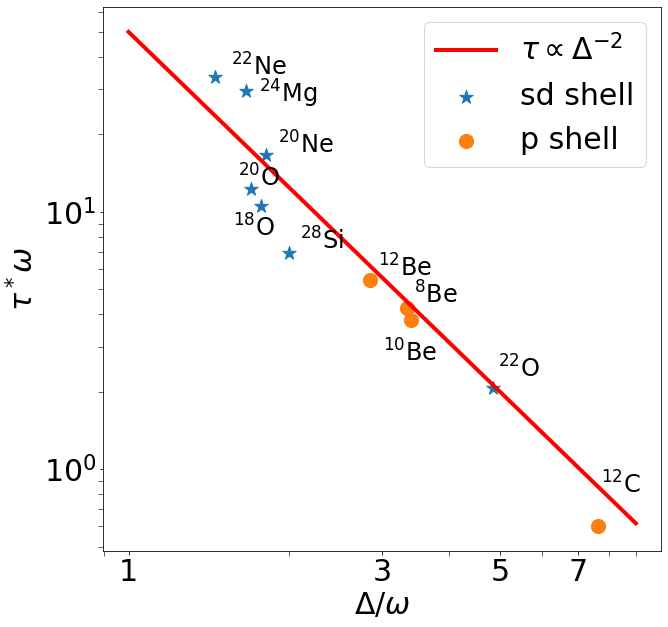

In [47]:
data=np.load('data/quantum_annealing_results/gap_vs_tau_usdb.npz')
data_2=np.load('data/quantum_annealing_results/gap_vs_tau_cki.npz')
data_3=np.load('data/quantum_annealing_results/gap_vs_tau_heavy.npz')
tau=data['tau']
gap=data['gap']
labels=data['labels']
tau_cki=data_2['tau']
gap_cki=data_2['gap']
print(tau_cki)
labels_cki=data_2['labels']
tau_heavy=data_3['tau']
#tau_heavy=[39,tau_heavy[-1]]
gap_heavy=data_3['gap']
#labels_heavy=data_3['labels']
print('labels_cki=',labels_cki)
labels=[r'$^{18}$O',r'$^{20}$O', r'$^{22}$O', r'$^{20}$Ne']
labels_cki=[r'$^{8}$Be',r'$^{10}$Be',r'$^{12}$C',r'$^{12}$Be',r'$^{8}Li$',r'$^{10}B$',r'$^{6}B$',r'$^{12}$B']
#[r'Be8',r'Be10',r'C12',r'Be12',r'Li8',r'B10',r'B6',r'B12']
labels_heavy=[r'$^{22}$Ne',r'$^{24}$Mg',r'$^{28}$Si']
gap[-2]=4.85
#labels=np.append(labels,labels_cki)
labels=np.append(labels,labels_heavy)
dim=[66,495,924,4356]
#gap=np.append(gap,gap_cki)
gap=np.append(gap,gap_heavy)
#tau=np.append(tau,tau_cki)
tau=np.append(tau,tau_heavy)
print(tau.shape,gap.shape)
coefficients = np.polyfit(np.log(gap), np.log(tau), 1)
slope, intercept = coefficients
print(coefficients)
plt.figure(figsize=(10,10))
plt.plot(np.linspace(1,9,10),50*(np.linspace(1,9,10)**(-2)),color='red',linewidth=4,label=r'$\tau \propto \Delta^{-2}$')
plt.scatter(gap,tau,marker='*',s=200,label='sd shell')
plt.scatter(gap_cki[:-4],tau_cki[:-4],s=200,label='p shell')
#plt.scatter(gap_cki[-4:],tau_cki[-4:],s=200,facecolors='none', edgecolors='orange',label='p shell')


# for sd shell
for i in range(gap.shape[0]):
    if labels[i]==r'$^{10}$Be' :
        plt.text(gap[i]-0.4,tau[i]+0.2,s=labels[i],fontsize=24)
    elif labels[i]==r'$^{20}$O':
        plt.text(gap[i]-0.1,tau[i]+0.2,s=labels[i],fontsize=24)
    elif labels[i]==r'$^{18}$O':
        plt.text(gap[i]-0.2,tau[i]-2.5,s=labels[i],fontsize=24)
    
    elif labels[i]==r'$^{24}$Mg':
        plt.text(gap[i]+0.1,tau[i]-3,s=labels[i],fontsize=24)
        
        
    else:
        plt.text(gap[i]+0.1,tau[i]+0.2,s=labels[i],fontsize=24)

# for the p shell
for i in range(gap_cki[:-4].shape[0]):
    if labels_cki[i]==r'$^{10}$Be' :
        plt.text(gap_cki[i]-0.4,tau_cki[i]-1.2,s=labels_cki[i],fontsize=24)
    elif labels_cki[i]==r'$^{20}$O':
        plt.text(gap_cki[i]-0.1,tau_cki[i]+0.2,s=labels_cki[i],fontsize=24)
    elif labels_cki[i]==r'$^{18}$O':
        plt.text(gap_cki[i]-0.1,tau_cki[i]-0.4,s=labels_cki[i],fontsize=24)
    
    elif labels_cki[i]==r'$^{24}$Mg':
        plt.text(gap_cki[i]+0.1,tau_cki[i]-3,s=labels_cki[i],fontsize=24)
        
        
    else:
        plt.text(gap_cki[i]+0.1,tau_cki[i]+0.2,s=labels_cki[i],fontsize=24)


# for i in range(gap_cki.shape[0]):
#     plt.text(gap_cki[i]+0.5,tau_cki[i]+0.5,s=labels_cki[i],fontsize=24)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=0,size=5,length=10)
plt.loglog()
plt.legend(fontsize=30)
plt.xlabel(r'$\Delta /\omega$',fontsize=30)
plt.ylabel(r'$\tau^* \omega$',fontsize=30)
plt.xticks(np.arange(1,9,2),np.arange(1,9,2))
plt.savefig("images/fig5", format="pdf", bbox_inches="tight")
plt.show()


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1.0 3.8131814444208056
0.9248441153572534


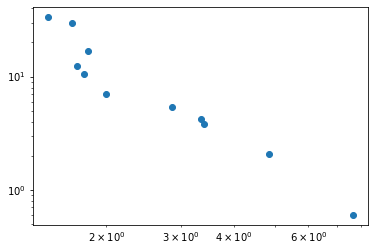

In [48]:
from scipy.optimize import curve_fit

gap=np.append(gap,gap_cki[:-4])
#gap=np.append(gap,gap_heavy)
tau=np.append(tau,tau_cki[:-4])
#tau=np.append(tau,tau_heavy)
plt.scatter(gap,tau)
plt.loglog()

# Define the linear function with constrained intercept (intercept = 0)
def linear_func(x, slope,intercept):
    return -2 * x+intercept

# Perform linear regression with constrained intercept using scipy.optimize.curve_fit
popt, pcov = curve_fit(linear_func, np.log(gap), np.log(tau))

slope = popt[0]
intercept=popt[1]
print(slope,intercept)
# Generate fitted values
y_fit = linear_func(np.log(gap), slope,intercept)

# Calculate R^2
ss_res = np.sum((np.log(tau) - y_fit)**2)
ss_tot = np.sum((np.log(tau) - np.mean(np.log(tau)))**2)
r_squared = 1 - (ss_res / ss_tot)

print(r_squared)

#### Fidelity vs dimension

In [ ]:
data=np.load('data/quantum_annealing_results/plot_results_fig2.npz')

fidelity=data['fidelity']
nparticles=data['particles']
labels=[lb for lb in data['labels']]

errors=data['errors']
print(labels)
dim=[51,84,51,5]
labels=[r'$^{8}$Be',r'$^{10}$Be',r'$^{12}$Be',r'$^{10}$B']

data_2=np.load('data/quantum_annealing_results/plot_results_fig2_usdb.npz')

fidelity_2=data_2['fidelity']
nparticles_2=data_2['particles']
labels_2=[lb for lb in data_2['labels']]
errors_2=data_2['errors']
print(labels_2)
dim_2=[14,81,142,640]
labels_2=[r'$^{18}$O',r'$^{20}$O', r'$^{22}$O', r'$^{20}$Ne']

data_3=np.load('data/quantum_annealing_results/plot_results_fig2_heavy_nuclei.npz')

fidelity_3=data_3['fidelity']
nparticles_2=data_3['particles']
labels_3=[r'$^{24}$Mg',r'$^{28}$Si']#[lb for lb in data_3['labels']]
errors_3=data_3['errors']
dim_3=[245025,853776]
print(labels_3)
print(fidelity_3.shape)
dims=dim+dim_2+dim_3
labels_tot=labels+labels_2+labels_3
fidelities_tot=np.append(fidelity[:,1],np.append(fidelity_2[:,1],fidelity_3[:,1]))





In [ ]:
print(fidelities_tot.shape,len(dims))
plt.figure(figsize=(10,10))
plt.scatter(dims[4:],1-fidelities_tot[4:],s=200,marker='*')

plt.scatter(dims[:4],1-fidelities_tot[:4],s=200,marker='o',color='orange')
for i in range(len(labels_tot)):
    plt.text(x=dims[i]*(1-0.3),y=(1-fidelities_tot[i])*(1+0.15),s=labels_tot[i],fontsize=20)
plt.xlabel(r'dim',fontsize=40)
plt.ylabel(r'$1-F$',fontsize=40)
plt.tick_params(which='major',labelsize=20)
plt.loglog()
plt.show()

##### Computational Cost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import comb

In [ ]:
d=np.arange(1,25)
nprotons=d//2
nneutrons=d//2
dimension=comb(d,nprotons)*comb(d,nneutrons)
comp_cost_20t=200*d**5
comp_cost_30t=300*d**5
comp_cost_10t=100*d**5
plt.figure(figsize=(10,10))
print(dimension)
plt.plot(d,comp_cost_20t,color='red',linewidth=3,label=r'$QA$')
#plt.fill_between()
#plt.plot(d,comp_cost_30t)
#plt.scatter([12],[comp_cost_20t[11]],s=300,color='red')
#plt.scatter([12],[dimension[11]],s=300,color='black')

#plt.scatter([6],[comp_cost_20t[5]],s=300,color='red')
#plt.scatter([6],[dimension[5]],s=300,color='black')
plt.text(x=4,y=10**7,s='p shell',fontsize=30,rotation=90)
plt.axvline(x=6,color='blue',linewidth=4,linestyle='--')
plt.text(x=10,y=10,s='sd shell',fontsize=30,rotation=90)
plt.axvline(x=12,color='blue',linewidth=4,linestyle='--')
plt.text(x=22,y=10,s='pf shell',fontsize=30,rotation=90)
plt.axvline(x=24,color='blue',linewidth=4,linestyle='--')
#plt.plot(d,comp_cost_10t)
plt.plot(d,dimension,color='black',linewidth=5,label=r'# many-body states')
plt.fill_between(x=d[:16],y1=comp_cost_20t[:16],y2=dimension[:16],alpha=0.3,color='grey')
plt.fill_between(x=d[15:],y1=comp_cost_20t[15:],y2=dimension[15:],alpha=0.3,color='green')
plt.semilogy()
plt.text(x=4,y=10**3,s='VQE advantage',fontsize=25,rotation=45)
plt.text(x=19,y=10**9,s='QA advantage',fontsize=20,rotation=45)
plt.tick_params(which='major',labelsize=30)
plt.ylabel(r'$N_{CNOT}$',fontsize=30)
plt.xlabel(r'$D/2$',fontsize=30)
plt.legend(fontsize=30)
plt.show()
